In [2]:
import pandas as pd
df_main = pd.read_csv('power_usage_2016_to_2020.csv')

In [3]:
df = df_main.copy()

In [4]:
df.columns

Index(['StartDate', 'Value (kWh)', 'day_of_week', 'notes'], dtype='object')

In [5]:
df.day_of_week.unique()

array([2, 5, 6, 4, 0, 1, 3])

In [6]:
df.notes.unique()

array(['weekday', 'weekend', 'vacation', 'COVID_lockdown'], dtype=object)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35952 entries, 0 to 35951
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   StartDate    35952 non-null  object 
 1   Value (kWh)  35952 non-null  float64
 2   day_of_week  35952 non-null  int64  
 3   notes        35952 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 1.1+ MB


In [8]:
df['StartDate'] = pd.to_datetime(df['StartDate'])
df['StartDate'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 35952 entries, 0 to 35951
Series name: StartDate
Non-Null Count  Dtype         
--------------  -----         
35952 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 281.0 KB


In [9]:
df['StartDate'].isnull().sum()

np.int64(0)

In [10]:
df['Value (kWh)'].isnull().sum()

np.int64(0)

In [11]:
print(df.head(5))
print(df.tail(5))

            StartDate  Value (kWh)  day_of_week    notes
0 2016-01-06 00:00:00        1.057            2  weekday
1 2016-01-06 01:00:00        1.171            2  weekday
2 2016-01-06 02:00:00        0.560            2  weekday
3 2016-01-06 03:00:00        0.828            2  weekday
4 2016-01-06 04:00:00        0.932            2  weekday
                StartDate  Value (kWh)  day_of_week    notes
35947 2020-07-07 19:00:00        1.307            1  weekday
35948 2020-07-07 20:00:00        2.872            1  weekday
35949 2020-07-07 21:00:00        2.138            1  weekday
35950 2020-07-07 22:00:00        2.199            1  weekday
35951 2020-07-07 23:00:00        1.809            1  weekday


In [12]:
df.set_index('StartDate',inplace=True)

In [13]:
df.loc['2016-01-06 00:00:00']

Value (kWh)      1.057
day_of_week          2
notes          weekday
Name: 2016-01-06 00:00:00, dtype: object

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df[['Value (kWh)']])
df['Value (kWh)'] = scaler.transform(df[['Value (kWh)']])
df['Value (kWh)'].head()

StartDate
2016-01-06 00:00:00    0.155594
2016-01-06 01:00:00    0.173457
2016-01-06 02:00:00    0.077719
2016-01-06 03:00:00    0.119712
2016-01-06 04:00:00    0.136008
Name: Value (kWh), dtype: float64

In [15]:
import numpy as np
window_size = 24
i = 0 
X = []
y = []
for i in range(len(df['Value (kWh)'])-window_size-1):
    x_window = df['Value (kWh)'].iloc[i : i + window_size].values  # 24 values
    y_target = df['Value (kWh)'].iloc[i + window_size] 
    X.append(x_window)
    y.append(y_target)
X = np.array(X)
y = np.array(y)

In [16]:
print("X shape:", X.shape)  # Should be (num_samples, 24)
print("y shape:", y.shape)  # Should be (num_samples,)

X shape: (35927, 24)
y shape: (35927,)


In [17]:
print("First input window (X[0]):", X[0])
print("Expected output (y[0]):", y[0])

print("\nSecond input window (X[1]):", X[1])
print("Expected output (y[1]):", y[1])

First input window (X[0]): [0.15559386 0.1734566  0.07771858 0.11971169 0.13600752 0.0421498
 0.0623629  0.06722031 0.04089627 0.03603886 0.03274835 0.10325917
 0.05672203 0.05593858 0.06001254 0.06769038 0.07192103 0.56142275
 0.46286431 0.51112504 0.33077405 0.45581322 0.45910373 0.2710749 ]
Expected output (y[0]): 0.19069257286117203

Second input window (X[1]): [0.1734566  0.07771858 0.11971169 0.13600752 0.0421498  0.0623629
 0.06722031 0.04089627 0.03603886 0.03274835 0.10325917 0.05672203
 0.05593858 0.06001254 0.06769038 0.07192103 0.56142275 0.46286431
 0.51112504 0.33077405 0.45581322 0.45910373 0.2710749  0.19069257]
Expected output (y[1]): 0.1731432152930116


In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# to check number of samples
print(len(X_train), len(X_test))  #To confirm your split didn’t miss or lose any data.
print(len(y_train), len(y_test))

28741 7186
28741 7186


In [19]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)
loss = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

C:\Users\Kaushik\jupyter_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0160 - val_loss: 0.0093
Epoch 2/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0077 - val_loss: 0.0069
Epoch 3/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0067 - val_loss: 0.0071
Epoch 4/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0062 - val_loss: 0.0064
Epoch 5/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0065 - val_loss: 0.0059
Epoch 6/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0055 - val_loss: 0.0058
Epoch 7/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0057 - val_loss: 0.0059
Epoch 8/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0053 - val_loss: 0.0057
Epoch 9/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0055 - val_loss: 0.0062
Epoch 10/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0054 - val_loss: 0.0056
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0048
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [25]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

r2 = r2_score(y_test, y_pred)
print("R² Score:", r2)

mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

R² Score: 0.742683156349778
MAE: 0.039780551267486086
MSE: 0.005068474981509618


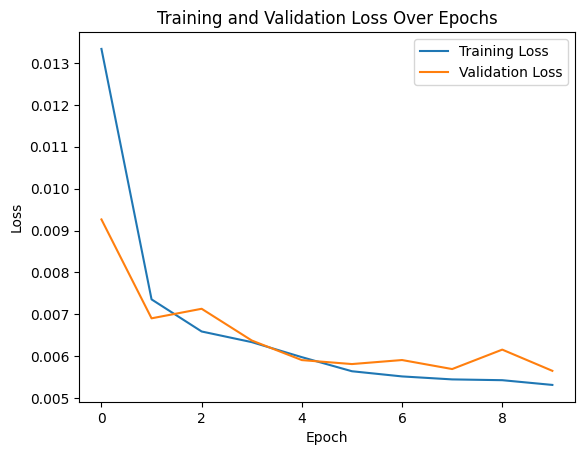

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

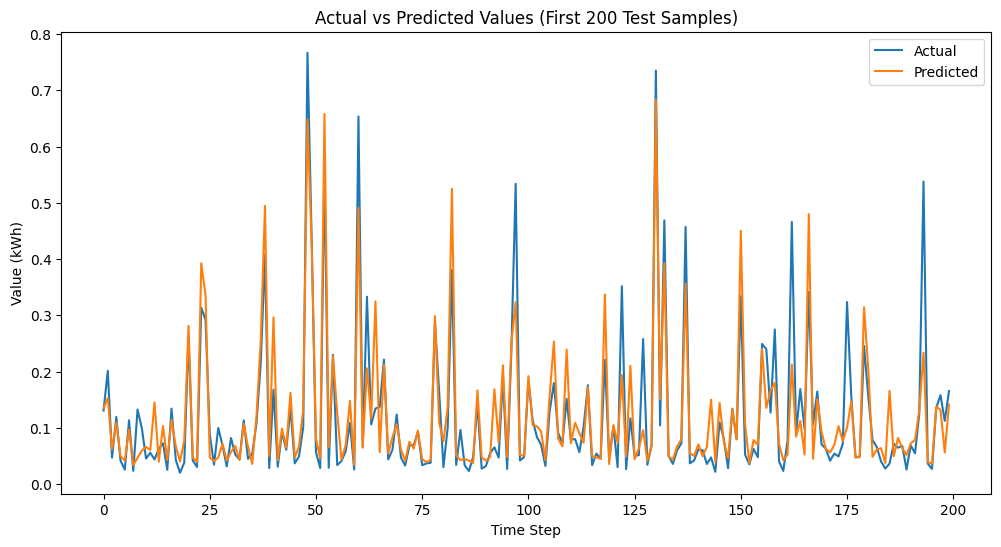

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(y_test[:200], label='Actual')
plt.plot(y_pred[:200], label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Values (First 200 Test Samples)')
plt.xlabel('Time Step')
plt.ylabel('Value (kWh)')
plt.show()